In [107]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.4.4
2.18.0


In [108]:
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [109]:
data_path = Path(r"C:\Users\user\OneDrive\바탕 화면")
# 데이터 경로 수정
train_path = Path(r"C:\Users\user\OneDrive\바탕 화면\outputtt.dat")

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep=',', header=None, usecols=[0, 1, 2],
                       parse_dates=[1], dtype={0: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['SessionId', 'Time', 'ItemId']
    return data

In [110]:
data = load_data(train_path, None)
data.sort_values(['SessionId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,SessionId,Time,ItemId
3,9537712,2014-08-27 20:38:34.103000+00:00,214537470
4,9537712,2014-08-27 20:39:41.005000+00:00,214717318
5,9537712,2014-08-27 20:46:12.423000+00:00,214717318
6,9537713,2014-08-28 07:19:34.883000+00:00,214853420
7,9537713,2014-08-28 07:20:37.459000+00:00,214850949
...,...,...,...
4727201,11562158,2014-09-26 04:50:29.172000+00:00,214849132
4727202,11562158,2014-09-26 04:52:21.900000+00:00,214854774
4727203,11562158,2014-09-26 05:16:32.904000+00:00,214849132
4727204,11562159,2014-09-26 19:16:28.897000+00:00,214849132


In [111]:
data['SessionId'].nunique(), data['ItemId'].nunique()

(1609315, 32468)

In [112]:
# UserID를 기준으로 세션 길이(각 사용자의 데이터 개수) 계산
session_length = data.groupby('SessionId').size()

# 세션 길이의 기본 통계 확인
print(session_length.describe())


count    1.609315e+06
mean     3.418012e+00
std      3.848943e+00
min      1.000000e+00
25%      2.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      2.000000e+02
dtype: float64


In [113]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1     0.224837
2     0.559814
3     0.711657
4     0.804682
5     0.858286
6     0.896023
7     0.920117
8     0.938151
9     0.950664
10    0.960455
11    0.967513
12    0.973294
13    0.977709
14    0.981339
15    0.984172
16    0.986506
17    0.988372
18    0.989960
19    0.991199
20    0.992296
21    0.993213
22    0.994012
23    0.994740
24    0.995334
25    0.995806
26    0.996235
27    0.996627
28    0.996968
29    0.997257
30    0.997522
31    0.997747
32    0.997955
33    0.998133
34    0.998285
35    0.998420
36    0.998557
37    0.998666
38    0.998763
39    0.998857
40    0.998946
dtype: float64

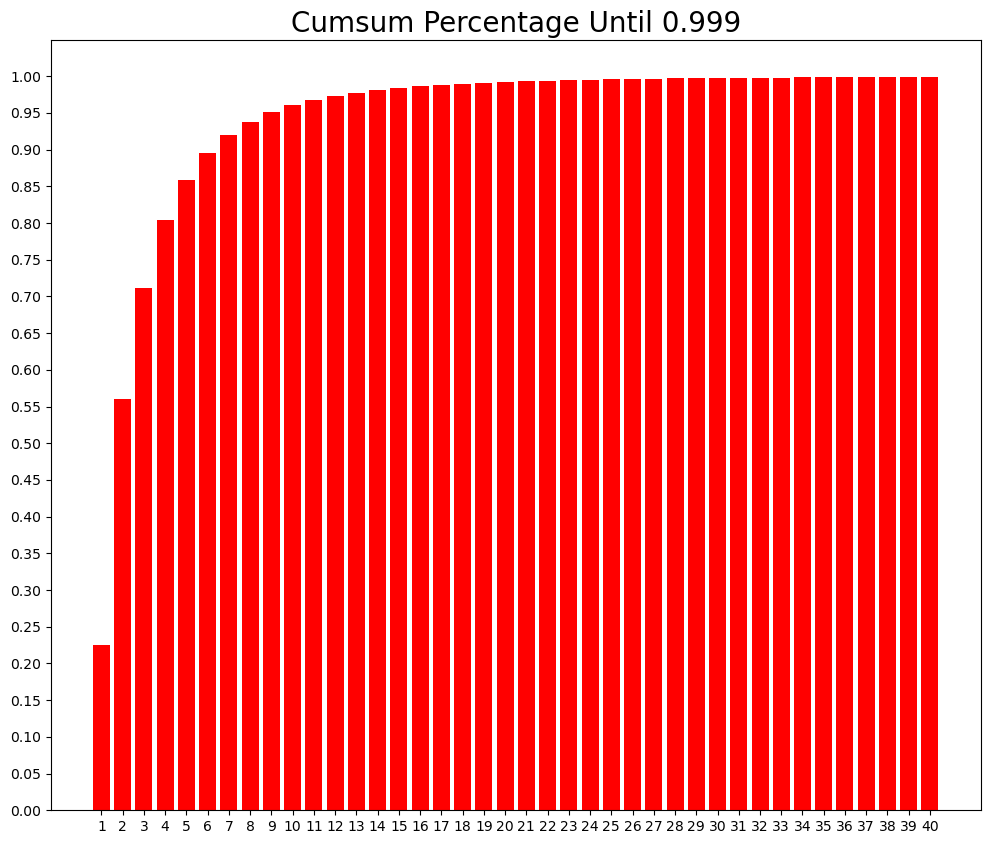

In [114]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [115]:
latest = data['Time'].max()

In [116]:
month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,SessionId,Time,ItemId
35,9537717,2014-08-31 15:00:29.594000+00:00,214546025
36,9537717,2014-08-31 15:02:49.518000+00:00,214546025
37,9537718,2014-09-01 13:33:14.476000+00:00,214846344
38,9537718,2014-09-01 13:33:58.909000+00:00,214821373
39,9537718,2014-09-01 13:39:52.763000+00:00,214850743
...,...,...,...
4727201,11562158,2014-09-26 04:50:29.172000+00:00,214849132
4727202,11562158,2014-09-26 04:52:21.900000+00:00,214854774
4727203,11562158,2014-09-26 05:16:32.904000+00:00,214849132
4727204,11562159,2014-09-26 19:16:28.897000+00:00,214849132


In [117]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [118]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,SessionId,Time,ItemId
35,9537717,2014-08-31 15:00:29.594000+00:00,214546025
36,9537717,2014-08-31 15:02:49.518000+00:00,214546025
37,9537718,2014-09-01 13:33:14.476000+00:00,214846344
38,9537718,2014-09-01 13:33:58.909000+00:00,214821373
39,9537718,2014-09-01 13:39:52.763000+00:00,214850743
...,...,...,...
4727199,11562157,2014-09-25 12:31:10.391000+00:00,214580372
4727200,11562157,2014-09-25 12:31:29.679000+00:00,214516012
4727201,11562158,2014-09-26 04:50:29.172000+00:00,214849132
4727202,11562158,2014-09-26 04:52:21.900000+00:00,214854774


In [119]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [120]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [121]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [122]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 4713454
	 Sessions: 1142499
	 Items: 19691
	 First Time : 2014-08-31 03:00:01.111000+00:00
	 Last Time : 2014-09-28 02:57:34.348000+00:00

* valid Set Stats Info
	 Events: 58062
	 Sessions: 12349
	 Items: 6221
	 First Time : 2014-09-28 03:00:25.298000+00:00
	 Last Time : 2014-09-29 02:58:27.660000+00:00

* test Set Stats Info
	 Events: 70995
	 Sessions: 15286
	 Items: 6569
	 First Time : 2014-09-29 02:37:20.695000+00:00
	 Last Time : 2014-09-30 02:59:59.430000+00:00



In [123]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [124]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [125]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,Time,ItemId,item_idx
35,9537717,2014-08-31 15:00:29.594000+00:00,214546025,0
36,9537717,2014-08-31 15:02:49.518000+00:00,214546025,0
37,9537718,2014-09-01 13:33:14.476000+00:00,214846344,1
38,9537718,2014-09-01 13:33:58.909000+00:00,214821373,2
39,9537718,2014-09-01 13:39:52.763000+00:00,214850743,3
40,9537718,2014-09-01 13:40:15.715000+00:00,214718169,4
41,9537718,2014-09-01 13:40:48.003000+00:00,214850758,5
73,9537729,2014-09-01 17:26:37.897000+00:00,214695095,6
74,9537729,2014-09-01 17:36:11.721000+00:00,214848249,7
69,9537731,2014-09-01 07:29:07.670000+00:00,214857039,8


In [126]:
tr_dataset.click_offsets

array([      0,       2,       7, ..., 4713449, 4713451, 4713454])

In [127]:
tr_dataset.session_idx

array([      0,       1,       2, ..., 1142496, 1142497, 1142498])

In [128]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [129]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,Time,ItemId,item_idx
35,9537717,2014-08-31 15:00:29.594000+00:00,214546025,0
36,9537717,2014-08-31 15:02:49.518000+00:00,214546025,0
37,9537718,2014-09-01 13:33:14.476000+00:00,214846344,1
38,9537718,2014-09-01 13:33:58.909000+00:00,214821373,2
39,9537718,2014-09-01 13:39:52.763000+00:00,214850743,3
40,9537718,2014-09-01 13:40:15.715000+00:00,214718169,4
41,9537718,2014-09-01 13:40:48.003000+00:00,214850758,5
73,9537729,2014-09-01 17:26:37.897000+00:00,214695095,6
74,9537729,2014-09-01 17:36:11.721000+00:00,214848249,7
69,9537731,2014-09-01 07:29:07.670000+00:00,214857039,8


In [130]:
iter_ex = iter(tr_data_loader)

In [131]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 1 6 8]
Label Item Idx are :       [0 2 7 9]
Previous Masked Input Idx are []


In [132]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [133]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [134]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size= 4)
tr_dataset.df.head()

,SessionId,Time,ItemId,item_idx
35,9537717,2014-08-31 15:00:29.594000+00:00,214546025,0
36,9537717,2014-08-31 15:02:49.518000+00:00,214546025,0
37,9537718,2014-09-01 13:33:14.476000+00:00,214846344,1
38,9537718,2014-09-01 13:33:58.909000+00:00,214821373,2
39,9537718,2014-09-01 13:39:52.763000+00:00,214850743,3


In [135]:
iter_ex = iter(tr_data_loader)

In [136]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 1 6 8]
Label Item Idx are :       [0 2 7 9]
Previous Masked Input Idx are []


In [137]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [138]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [139]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [140]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [141]:
model = create_model(args)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (2048, 1, 19691)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU (GRU)                       │ [(2048, 50), (2048,    │     2,961,450 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (2048, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (2048, 19691)          │     1,004,241 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,965,691 (15.13 MB)

 Trainable params: 3,965,691 (15.13 MB)

 Non-trainable params: 0 (0.00 B)

In [142]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states()


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [152]:
model.save('movie_model.h5')

In [153]:
model = tf.keras.models.load_model('movie_model.h5')

In [154]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:   0%|          | 0/27 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step


Evaluation:   4%|▎         | 1/27 [00:24<10:43, 24.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Evaluation:   7%|▋         | 2/27 [01:25<19:09, 45.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


Evaluation:  11%|█         | 3/27 [01:58<16:01, 40.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Evaluation:  15%|█▍        | 4/27 [02:19<12:30, 32.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Evaluation:  19%|█▊        | 5/27 [02:41<10:32, 28.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Evaluation:  22%|██▏       | 6/27 [03:03<09:12, 26.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Evaluation:  26%|██▌       | 7/27 [03:24<08:14, 24.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Evaluation:  30%|██▉       | 8/27 [03:45<07:28, 23.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Evaluation:  33%|███▎      | 9/27 [04:12<07:21, 24.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Evaluation:  37%|███▋      | 10/27 [04:34<06:45, 23.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Evaluation:  41%|████      | 11/27 [04:56<06:11, 23.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Evaluation:  44%|████▍     | 12/27 [05:17<05:38, 22.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Evaluation:  48%|████▊     | 13/27 [05:40<05:16, 22.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Evaluation:  52%|█████▏    | 14/27 [06:01<04:50, 22.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Evaluation:  56%|█████▌    | 15/27 [06:23<04:24, 22.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Evaluation:  59%|█████▉    | 16/27 [06:44<04:00, 21.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Evaluation:  63%|██████▎   | 17/27 [07:06<03:38, 21.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Evaluation:  67%|██████▋   | 18/27 [07:28<03:16, 21.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Evaluation:  70%|███████   | 19/27 [07:50<02:54, 21.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Evaluation:  74%|███████▍  | 20/27 [08:12<02:32, 21.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Evaluation:  78%|███████▊  | 21/27 [08:34<02:12, 22.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Evaluation:  81%|████████▏ | 22/27 [08:59<02:02, 24.52s/it]

	 - Recall@20: 0.001287
	 - MRR@20: 0.000259

